In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import seaborn as sns
import numpy as np
dcolors = plt.cm.tab10.colors
from pathlib import Path
import statsmodels.formula.api as sm
from scipy.stats import linregress
import scipy.stats as st
sns.set_theme(font_scale = 1, style = 'ticks')

from scikit_posthocs import posthoc_dunn, posthoc_conover
from statannotations.Annotator import Annotator
import itertools 

In [2]:
git_folder = Path('../../..')
figure_folder = git_folder / 'Figures'

In [3]:
fn = git_folder / 'data' / 'other'/'A_rates_and_values.csv'
df_rates = pd.read_csv(fn, index_col=0)
# df_rates = df_rates.loc[~df_rates['Rate [mmol/gDW/h]'].isna()]

In [4]:
fn_classification = git_folder / 'data'/'this_project'/'5_div'/'5D_classyfire_classification.csv'
df_classyfire = pd.read_csv(fn_classification, index_col=0)
met_to_class = df_classyfire.set_index('Metabolite')['Defined class'].to_dict()

In [5]:
df_rates['Compound class'] = df_rates.Metabolite.map(met_to_class)

In [6]:
df_rates.rename(columns = {'xlogP': 'log P'}, inplace=True)
df_rates['log10(Intracellular conc. [M])'] = np.log10(df_rates['Intracellular concentration [M]'])


In [7]:
df_rates.replace({'Species': {'Ecoli': 'E. coli', 'Pputida': 'P. putida'}}, inplace=True)

# Simple linear model of E. coli in controlled conditions


In [8]:
df_mean = df_rates.groupby(['Carbon source', 'Species', 'Metabolite', 'Dataset']).mean(numeric_only=True)
df_mean.reset_index(inplace=True)
df_mean['Compound class'] = df_mean.Metabolite.map(met_to_class)

df_mean.replace([np.inf, -np.inf], np.nan, inplace=True)

df_mean_ecoli = df_mean.loc[(df_mean.Species=='E. coli')&(df_mean.Dataset != 'Vila-23')].copy()


In [9]:
df_mean_ecoli.dropna(subset=['Rate [mmol/gDW/h]', 'Metabolite value [gDW/mmol]'], inplace=True)


In [10]:
df_mean_ecoli['Compound class'].unique()

array(['Carboxylic acids', 'Amino acids', 'Keto / hydroxy acids', 'Other',
       'Organooxygen compounds'], dtype=object)

In [11]:
key_to_col = {
    'Y':'log10(Rate [mmol/gDW/h])',
    'A':'log10(Intracellular conc. [M])',
    'B':'log10(Metabolite value [gDW/mmol])',
    'C':'Charge',
    'D':'Mol weight [g/mol]',
    'E':'log P',
    'F':'log10(Turnover [mmol/gDW/h])',
    'R':'Rotatable Bond Count',
    'S':'Hydrogen Bond Donor Count',
    'T':'Hydrogen Bond Acceptor Count',
    'U':'Topological Polar Surface Area',
    'G':'Compound class',
    'H':'Carbon source',
    # 'V':'Simplified class',
}
lindf = pd.DataFrame()
lindf['Y'] = df_mean_ecoli['log10(Rate [mmol/gDW/h])']
lindf['A'] = df_mean_ecoli['log10(Intracellular conc. [M])']
lindf['B'] = df_mean_ecoli['log10(Metabolite value [gDW/mmol])']
lindf['C'] = df_mean_ecoli['Charge']
lindf['D'] = df_mean_ecoli['Mol weight [g/mol]']
lindf['E'] = df_mean_ecoli['log P']
lindf['F'] = df_mean_ecoli['log10(Turnover [mmol/gDW/h])'].copy()
lindf['R'] = df_mean_ecoli['Rotatable Bond Count']
lindf['S'] = df_mean_ecoli['Hydrogen Bond Donor Count']
lindf['T'] = df_mean_ecoli['Hydrogen Bond Acceptor Count']
lindf['U'] = df_mean_ecoli['Topological Polar Surface Area']
lindf['G'] = df_mean_ecoli['Compound class']
lindf['H'] = df_mean_ecoli['Carbon source']
lindf['G'] = pd.Categorical(lindf['G'], categories=lindf.G.unique())
lindf['Metabolite'] = df_mean_ecoli['Metabolite']


# lindf['I'] = df_mean_ecoli['Dataset']

# lindf['V'] = lindf.G.map(simplify_class)
lindf.fillna({'F':-4}, inplace = True)

lindf.dropna(inplace=True)

var_explained = {}
for key, col_name in key_to_col.items():
    if col_name == 'log10(Rate [mmol/gDW/h])':
        continue
    if key not in lindf.columns:
        continue
    res = sm.ols(formula=f"Y ~ {key}", data=lindf).fit()
    var_explained[col_name] = res.rsquared
    print(key, col_name, f'R2: {res.rsquared:.2f}')
    # print(res.summary2())

ols_model =  sm.ols(formula="Y ~ A+B+C+G", data=lindf)
res = ols_model.fit()
var_explained['log10(MV) + log10(IC) + Charge + C class'] = res.rsquared
print(var_explained)
df_r2 = pd.DataFrame(var_explained, index = ['Variability explained']).T.reset_index(names = 'Parameter').sort_values(by= 'Variability explained', ascending = False)
# Export the OLS summary to a CSV file
summary_df = res.summary2().tables[1]  # Extract the coefficients table as a DataFrame
summary_df.to_csv(figure_folder / 'ols_summary.csv')


A log10(Intracellular conc. [M]) R2: 0.08
B log10(Metabolite value [gDW/mmol]) R2: 0.43
C Charge R2: 0.04
D Mol weight [g/mol] R2: 0.11
E log P R2: 0.19
F log10(Turnover [mmol/gDW/h]) R2: 0.04
R Rotatable Bond Count R2: 0.19
S Hydrogen Bond Donor Count R2: 0.18
T Hydrogen Bond Acceptor Count R2: 0.05
U Topological Polar Surface Area R2: 0.05
G Compound class R2: 0.29
H Carbon source R2: 0.04
{'log10(Intracellular conc. [M])': np.float64(0.07653525742533884), 'log10(Metabolite value [gDW/mmol])': np.float64(0.4298784611117007), 'Charge': np.float64(0.03593401599726698), 'Mol weight [g/mol]': np.float64(0.11347823733697782), 'log P': np.float64(0.18731011613421622), 'log10(Turnover [mmol/gDW/h])': np.float64(0.04207654819085538), 'Rotatable Bond Count': np.float64(0.1940986877405484), 'Hydrogen Bond Donor Count': np.float64(0.1786975611653263), 'Hydrogen Bond Acceptor Count': np.float64(0.045831775287176746), 'Topological Polar Surface Area': np.float64(0.053453413238113145), 'Compound c

In [12]:
ols_model =  sm.ols(formula="Y ~ B+C+G", data=lindf)
res = ols_model.fit()
res.summary2()
summary_df = res.summary2().tables[1]  # Extract the coefficients table as a DataFrame
summary_df.to_csv(figure_folder / 'ols_summary_value_group_charge.csv')

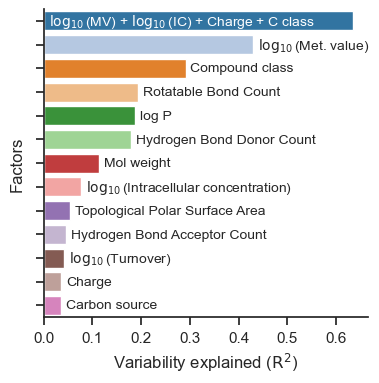

In [13]:

fig, ax = plt.subplots(1, figsize = (4,4))
# ax.barh(y = np.arange(i+1), width = r_squared_list)
# ax.set_yticks(np.arange(i+1), x_axis_list)
# df_r2 = pd.DataFrame()
# df_r2['R2'] = r_squared_list
# df_r2['Parameter'] = x_axis_list
# df_r2.sort_values('R2', inplace=True, ascending=False)

# Replace 'log10' in the 'Parameter' column with LaTeX-style formatting
df_r2['Parameter name'] = df_r2['Parameter'].str.replace('log10', r'$\log_{10}$', regex=False)
df_r2.replace({'Parameter name': {r'$\log_{10}$(Metabolite value [gDW/mmol])': r'$\log_{10}$(Met. value)',
                                  'Mol weight [g/mol]': 'Mol weight',
                                  r'$\log_{10}$(Intracellular conc. [M])': r'$\log_{10}$(Intracellular concentration)',
                                   r'$\log_{10}$(Turnover [mmol/gDW/h])':  r'$\log_{10}$(Turnover)',}}, inplace=True),

g = sns.barplot(data = df_r2, x = 'Variability explained', y = 'Parameter name', palette='tab20', hue = 'Parameter name', ax = ax)

                # order = [df_r2.Parameter[1:]+df_r2.Parameter[0]])#, hue_order= df_r2.Parameter)#
# g.set_xticks([0, 0.1, 0.2, 0.3,0.4])
# Remove the default y-axis labels
ax.set_yticklabels([])

# Add custom labels at the end of the bars
for i, (value, label) in enumerate(zip(df_r2['Variability explained'], df_r2['Parameter name'])):
    if i < 1:
        ax.text(0.01, i, label, #label.replace('$\log_{10}$', '$\mathbf{log_{10}}$'),
                va='center', ha='left', fontsize=10, color='w')#, weight = 'bold')
    else:
        ax.text(value + 0.01, i, label, va='center', ha='left', fontsize=10)  # Adjust `+ 0.01` for spacing

sns.despine()
ax.set_xlabel(r"Variability explained ($\rm{R^2}$)", )
ax.set_ylabel("Factors")
# ax.set_ylim(0,0.5)
plt.tight_layout()
plt.savefig(figure_folder / "Variability_explained_ecoli_std.pdf")

# Try all different linear models

In [14]:
n = 0
adjusted_r2_data = []
letters = 'ABCDEFGHRSTU'
for x in range(1, len(letters)+1, 1):
    for x in itertools.combinations(letters, x):
        rhs = " + ".join(x)
        ols_model =  sm.ols(formula=f"Y ~ {rhs}", data=lindf)
        res = ols_model.fit()
        adjusted_r2_data.append([x, len(x), res.rsquared_adj, res.rsquared, res.aic, res.bic, res.df_model])
        n+=1
        
adjusted_r2_df = pd.DataFrame(adjusted_r2_data, columns = ['Combination', 'N', 'rsquared_adj', 'rsquared', 'aic', 'bic', 'df'])

In [15]:
adjusted_r2_df.sort_values(by = 'rsquared_adj', ascending=False, inplace=True)
adjusted_r2_df.reset_index(inplace=True, drop=True)

In [16]:
adjusted_r2_df['Contains B'] = adjusted_r2_df.Combination.apply(lambda x: 'B' in x)
adjusted_r2_df['Contains BG'] = adjusted_r2_df.Combination.apply(lambda x: 'B' in x and 'G' in x)
adjusted_r2_df['Contains B or G'] = adjusted_r2_df.Combination.apply(lambda x: 'B' in x or 'G' in x)
adjusted_r2_df['Contains ABG'] = adjusted_r2_df.Combination.apply(lambda x: set('ABG') <= set(str(x)))

In [17]:
adjusted_r2_df.sort_values('bic').head(10)

,Combination,N,rsquared_adj,rsquared,aic,bic,df,Contains B,Contains BG,Contains B or G,Contains ABG
510,"(A, B, C, G)",4,0.604046,0.634504,238.185591,258.359900,7.0,True,True,True,True
362,"(A, B, C, D, G)",5,0.616864,0.650546,236.056360,258.752457,8.0,True,True,True,True
388,"(A, C, D, E, G)",5,0.614295,0.648203,236.671140,259.367237,8.0,False,False,True,False
412,"(A, B, C, G, T)",5,0.611676,0.645814,237.293819,259.989916,8.0,True,True,True,True
248,"(A, B, C, D, E, G)",6,0.625104,0.662182,234.940852,260.158738,9.0,True,True,True,True
249,"(A, C, D, E, G, S)",6,0.625045,0.662128,234.955532,260.173418,9.0,False,False,True,False
436,"(A, B, C, G, R)",5,0.609833,0.644134,237.729259,260.425356,8.0,True,True,True,True
277,"(A, B, C, E, G, T)",6,0.623448,0.660689,235.346582,260.564468,9.0,True,True,True,True
278,"(A, B, C, D, G, U)",6,0.623437,0.660679,235.349237,260.567123,9.0,True,True,True,True
457,"(A, E, G, S, T)",5,0.608449,0.642871,238.055099,260.751197,8.0,False,False,True,False


In [18]:
adjusted_r2_df.loc[~adjusted_r2_df['Contains B']].sort_values('bic').head(10)

,Combination,N,rsquared_adj,rsquared,aic,bic,df,Contains B,Contains BG,Contains B or G,Contains ABG
388,"(A, C, D, E, G)",5,0.614295,0.648203,236.671140,259.367237,8.0,False,False,True,False
249,"(A, C, D, E, G, S)",6,0.625045,0.662128,234.955532,260.173418,9.0,False,False,True,False
457,"(A, E, G, S, T)",5,0.608449,0.642871,238.055099,260.751197,8.0,False,False,True,False
332,"(A, E, G, S, T, U)",6,0.619662,0.657277,236.266948,261.484834,9.0,False,False,True,False
338,"(A, C, E, G, S, T)",6,0.619191,0.656853,236.380757,261.598642,9.0,False,False,True,False
3,"(A, C, D, E, G, H, S)",7,0.658887,0.703869,228.824023,261.607274,12.0,False,False,True,False
70,"(A, C, D, E, G, H)",6,0.645729,0.688553,231.463253,261.724716,11.0,False,False,True,False
365,"(A, E, F, G, S, T)",6,0.616424,0.654360,237.046780,262.264666,9.0,False,False,True,False
540,"(A, C, E, G, T)",5,0.601136,0.636201,239.757605,262.453703,8.0,False,False,True,False
722,"(A, C, D, G)",4,0.584733,0.616677,242.567032,262.741341,7.0,False,False,True,False


In [19]:
adjusted_r2_df.loc[~adjusted_r2_df['Contains B or G']].sort_values('rsquared_adj', ascending=False).head(10)

,Combination,N,rsquared_adj,rsquared,aic,bic,df,Contains B,Contains BG,Contains B or G,Contains ABG
2929,"(A, D, E, H, R, S, U)",7,0.433324,0.489369,272.949766,298.167652,9.0,False,False,False,False
2934,"(A, C, D, H, R, S, U)",7,0.432005,0.488180,273.163736,298.381622,9.0,False,False,False,False
2938,"(A, D, E, H, R, U)",6,0.431413,0.481399,272.374584,295.070681,8.0,False,False,False,False
2942,"(A, D, E, H, R, S, T, U)",8,0.430804,0.493353,274.229161,301.968835,10.0,False,False,False,False
2950,"(A, C, D, E, H, R, S, U)",8,0.429458,0.492155,274.446467,302.186142,10.0,False,False,False,False
2966,"(A, D, E, F, H, R, S, U)",8,0.426631,0.489638,274.901221,302.640895,10.0,False,False,False,False
2968,"(A, C, D, F, H, R, S, U)",8,0.426529,0.489548,274.917566,302.657241,10.0,False,False,False,False
2970,"(A, D, E, H, R, T, U)",7,0.425920,0.482697,274.144017,299.361903,9.0,False,False,False,False
2978,"(A, C, D, H, R, S, T, U)",8,0.425039,0.488222,275.156205,302.895879,10.0,False,False,False,False
2979,"(A, D, E, F, H, R, U)",7,0.424796,0.481684,274.323953,299.541839,9.0,False,False,False,False


In [20]:
adjusted_r2_df.loc[adjusted_r2_df.df<7].head(10)

,Combination,N,rsquared_adj,rsquared,aic,bic,df,Contains B,Contains BG,Contains B or G,Contains ABG
1421,"(A, B, E, R, T, U)",6,0.538939,0.569339,251.279798,268.932318,6.0,True,False,True,False
1538,"(A, B, E, T, U)",5,0.530483,0.556281,252.027854,267.158586,5.0,True,False,True,False
1545,"(A, B, E, S, T, U)",6,0.530170,0.561148,253.013202,270.665722,6.0,True,False,True,False
1552,"(A, B, E, H)",4,0.529709,0.560717,253.103464,270.755984,6.0,True,False,True,False
1608,"(A, B, C, E, T, U)",6,0.526363,0.557592,253.755639,271.408159,6.0,True,False,True,False
1616,"(A, B, E, F, T, U)",6,0.526023,0.557275,253.821574,271.474094,6.0,True,False,True,False
1621,"(A, B, C, D, E, U)",6,0.525674,0.556948,253.889344,271.541864,6.0,True,False,True,False
1636,"(A, B, D, E, T, U)",6,0.525073,0.556387,254.005776,271.658296,6.0,True,False,True,False
1640,"(B, C, G)",3,0.524943,0.556266,254.030974,271.683494,6.0,True,True,True,False
1679,"(A, B, R, S, T, U)",6,0.523325,0.554754,254.343909,271.996429,6.0,True,False,True,False


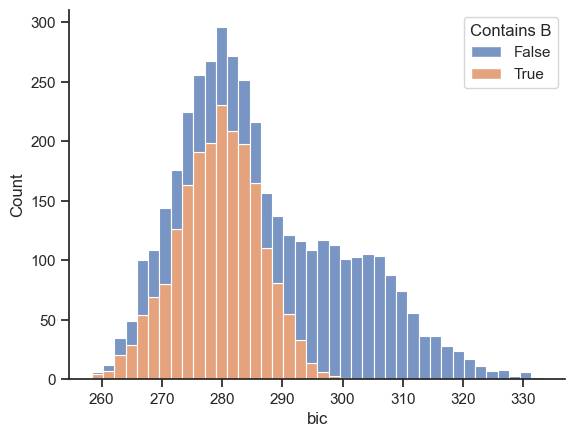

In [21]:

ax = sns.histplot(data = adjusted_r2_df, x = 'bic', bins = 40, hue = 'Contains B', multiple="stack")
sns.despine()

In [22]:
adjusted_r2_df.sort_values(by='bic', ascending=True, inplace=True)
selected = adjusted_r2_df.iloc[0]
selected_no_B = adjusted_r2_df.loc[~adjusted_r2_df['Contains B']].iloc[0]

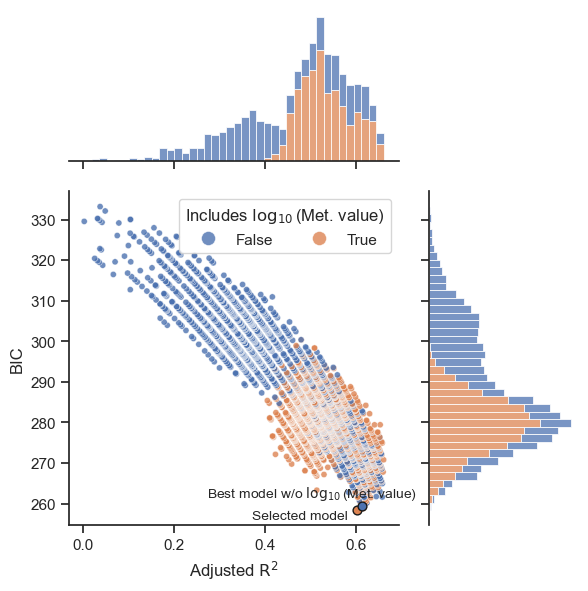

In [23]:
g = sns.JointGrid(data=adjusted_r2_df, x='rsquared_adj', y='bic', hue='Contains B', palette=['C0', 'C1'], ratio = 2)

# Scatter plot on joint axis
sns.scatterplot(data = adjusted_r2_df, x = 'rsquared_adj', y = 'bic', hue = 'Contains B', alpha=0.8, s=20,
                  ax = g.ax_joint,)


sns.histplot(data = adjusted_r2_df, y = 'bic', bins = 40, hue = 'Contains B', multiple="stack", ax = g.ax_marg_y, legend=False)
sns.histplot(data = adjusted_r2_df, x = 'rsquared_adj', bins = 40, hue = 'Contains B', multiple="stack", ax = g.ax_marg_x, legend=False)

leg = g.ax_joint.legend(ncol=2)
leg.set_title(r"Includes $\log_{10}$(Met. value)")
for handle in leg.legend_handles:
    handle.set_markersize(10)
g.ax_joint.set_xlabel(r"Adjusted $\rm{R^2}$")
g.ax_joint.set_ylabel("BIC")

g.ax_joint.scatter(x = selected.rsquared_adj, y = selected.bic, color='C1', s=40, label='Selected model', edgecolors='k')
g.ax_joint.annotate('Selected model', xy=(selected.rsquared_adj, selected.bic), xytext=(selected.rsquared_adj - 0.02, selected.bic),
                    ha='right', va='top', size = 10)

g.ax_joint.scatter(x = selected_no_B.rsquared_adj, y = selected_no_B.bic, color='C0', s=40, label='Selected model', edgecolors='k')
g.ax_joint.annotate(r"Best model w/o $\log_{10}$(Met. value)", xy=(selected.rsquared_adj, selected.bic), xytext=(selected.rsquared_adj-0.1, selected.bic+2),
                    ha='center', va='bottom', size=10)

plt.savefig(figure_folder / "Adjusted_R2_vs_BIC.pdf", bbox_inches='tight')

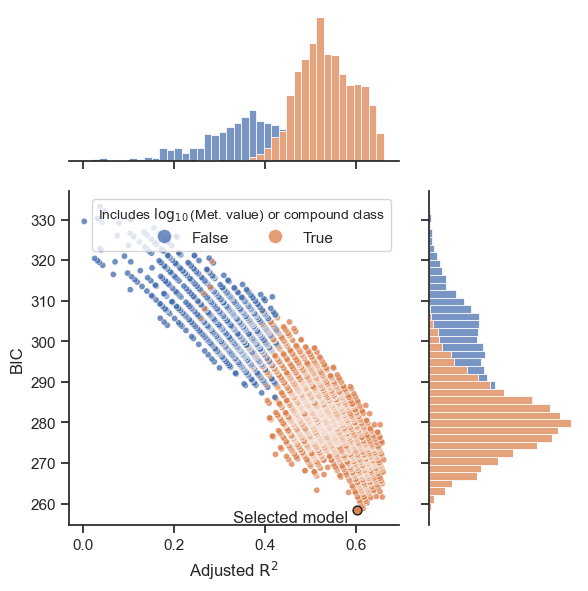

In [24]:
g = sns.JointGrid(data=adjusted_r2_df, x='rsquared_adj', y='bic', hue='Contains B or G', palette=['C0', 'C1'], ratio = 2)

# Scatter plot on joint axis
sns.scatterplot(data = adjusted_r2_df, x = 'rsquared_adj', y = 'bic', hue = 'Contains B or G', alpha=0.8, s=20,
                  ax = g.ax_joint,)


sns.histplot(data = adjusted_r2_df, y = 'bic', bins = 40, hue = 'Contains B or G', multiple="stack", ax = g.ax_marg_y, legend=False)
sns.histplot(data = adjusted_r2_df, x = 'rsquared_adj', bins = 40, hue = 'Contains B or G', multiple="stack", ax = g.ax_marg_x, legend=False)

leg = g.ax_joint.legend(ncol=2)
leg.set_title(r"Includes $\log_{10}$(Met. value) or compound class", prop={'size': 10})
for handle in leg.legend_handles:
    handle.set_markersize(10)
g.ax_joint.set_xlabel(r"Adjusted $\rm{R^2}$")
g.ax_joint.set_ylabel("BIC")

# selected = adjusted_r2_df.iloc[510]
g.ax_joint.scatter(x = selected.rsquared_adj, y = selected.bic, color='C1', s=40, label='Selected model', edgecolors='k')
g.ax_joint.annotate('Selected model', xy=(selected.rsquared_adj, selected.bic), xytext=(selected.rsquared_adj - 0.02, selected.bic),
                    ha='right', va='top')


plt.savefig(figure_folder / "Adjusted_R2_vs_BIC_B_or_G.pdf", bbox_inches='tight')

<Axes: xlabel='rsquared_adj', ylabel='Count'>

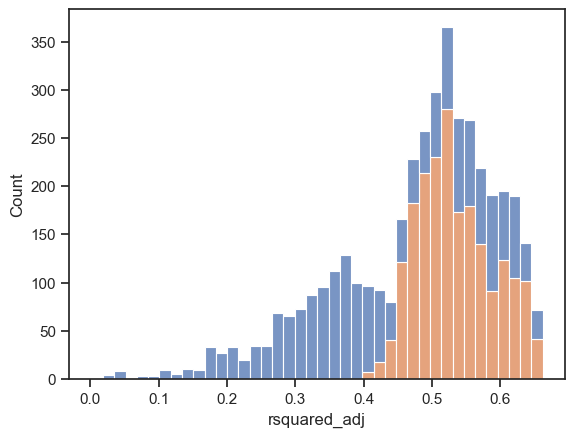

In [25]:
sns.histplot(data = adjusted_r2_df, x = 'rsquared_adj', bins = 40, hue = 'Contains B', multiple="stack", legend=False)


In [26]:
g.ax_marg_x.get_xticklabels()

[]

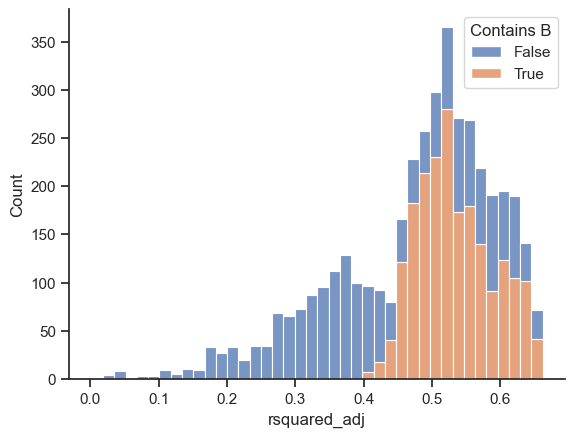

In [27]:
sns.histplot(data = adjusted_r2_df, x = 'rsquared_adj', bins = 40, hue = 'Contains B', multiple="stack")
sns.despine()

In [28]:
adjusted_r2_df.loc[~adjusted_r2_df['Contains B']].sort_values('bic', ascending=True).head(10)

,Combination,N,rsquared_adj,rsquared,aic,bic,df,Contains B,Contains BG,Contains B or G,Contains ABG
388,"(A, C, D, E, G)",5,0.614295,0.648203,236.671140,259.367237,8.0,False,False,True,False
249,"(A, C, D, E, G, S)",6,0.625045,0.662128,234.955532,260.173418,9.0,False,False,True,False
457,"(A, E, G, S, T)",5,0.608449,0.642871,238.055099,260.751197,8.0,False,False,True,False
332,"(A, E, G, S, T, U)",6,0.619662,0.657277,236.266948,261.484834,9.0,False,False,True,False
338,"(A, C, E, G, S, T)",6,0.619191,0.656853,236.380757,261.598642,9.0,False,False,True,False
3,"(A, C, D, E, G, H, S)",7,0.658887,0.703869,228.824023,261.607274,12.0,False,False,True,False
70,"(A, C, D, E, G, H)",6,0.645729,0.688553,231.463253,261.724716,11.0,False,False,True,False
365,"(A, E, F, G, S, T)",6,0.616424,0.654360,237.046780,262.264666,9.0,False,False,True,False
540,"(A, C, E, G, T)",5,0.601136,0.636201,239.757605,262.453703,8.0,False,False,True,False
722,"(A, C, D, G)",4,0.584733,0.616677,242.567032,262.741341,7.0,False,False,True,False


<Axes: xlabel='rsquared_adj', ylabel='Count'>

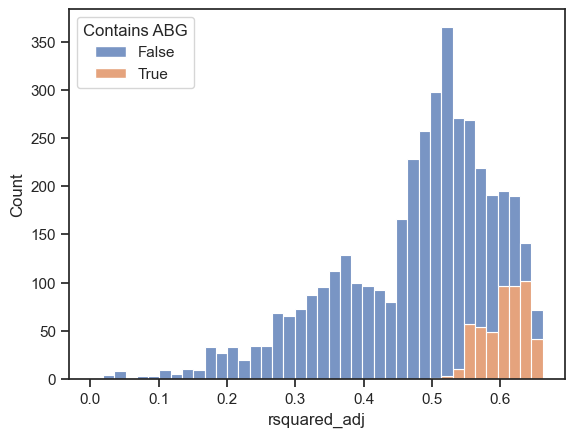

In [29]:
adjusted_r2_df['Contains ABG'] = adjusted_r2_df.Combination.apply(lambda x: set('ABG') <= set(str(x)))
sns.histplot(data = adjusted_r2_df, x = 'rsquared_adj', bins = 40, hue = 'Contains ABG', multiple="stack")

## Leave one out

In [30]:
cs_list = df_mean_ecoli['Carbon source'].unique()
lindf3 = lindf.copy()
# lindf3.replace({'Phosphorylated sugar':'Other'}, inplace=True)
lindf3.sort_values(by='H', inplace=True)
# phos_param ='G[T.Phosphorylated sugar]'
# xcolumns = ['A', 'B', 'G', 'C']
lindf3['G'] = pd.Categorical(lindf3['G'], categories=lindf3.G.unique())
full_model =  sm.ols(formula="Y ~ A + B + G + C", data=lindf3)
full_res = full_model.fit()
y_preds2 = []
y_vals2 = []
for cs in cs_list:
    cidx = lindf3['H']== cs # "Carbon source" is represented by H in this df
    train_model = sm.ols(formula="Y ~ A + B + G + C", data=lindf3.loc[~cidx])
    train_res = train_model.fit()
    yp = train_res.predict(lindf3.loc[cidx, ['A', 'B', 'G', 'C']])
    # test_model = sm.ols(formula="Y ~ A + B + G + C", data=lindf3.loc[cidx])
    # yp = test_model.predict(params=train_res.params, exog = full_model.exog[cidx])
    y_vals2 += list(lindf3.loc[cidx, 'Y'].values)
    y_preds2 += list(yp)
    print(len(y_vals2))
    # y_pred = ols_model.predict(params = res.params, exog = lindf.loc[midx, xcolumns].T)
    # print(m, ols_model.exog.shape,res_full.rsquared_adj, res.rsquared_adj)



18
55
76
92


0.45016312787704094


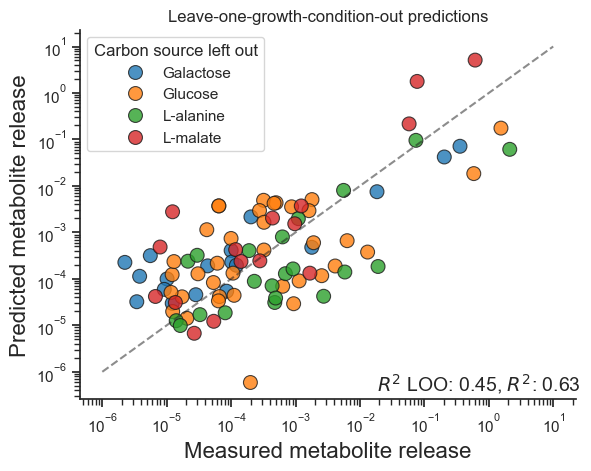

In [31]:
pred_df = pd.DataFrame()
pred_df['Predicted'] = y_preds2
pred_df['Measured'] = y_vals2
pred_df['Carbon source'] = list(lindf3['H'])
# ax = sns.scatterplot(data = pred_df, x = 'Measured', y = 'Predicted', hue = 'Carbon source', s = 100)
pred_df['Measured metabolite release'] = 10**pred_df['Measured']
pred_df['Predicted metabolite release'] = 10**pred_df['Predicted']
ax = sns.scatterplot(data = pred_df, x = 'Measured metabolite release', y = 'Predicted metabolite release', hue = 'Carbon source', s = 100,
                     edgecolor='k', palette = 'tab10', alpha = 0.8)
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_xlim(1,1000)
ax.legend(title = 'Carbon source left out')
ax.set(xscale="log", yscale="log")
sns.despine()
llog = np.logspace(-6, 1)
ax.plot(llog,llog,c='k',ls = '--', alpha = 0.5)

y_preds_arr2 = np.array(y_preds2)
y_vals_arr2 = np.array(y_vals2)

SSres = np.sum((y_preds_arr2-y_vals_arr2)**2)
SStot = np.sum((y_vals_arr2-np.mean(y_vals_arr2))**2)
R2 = 1-(SSres/SStot)
print(R2)


plt.xlabel('Measured metabolite release', fontdict={'size': 16})
plt.ylabel('Predicted metabolite release', fontdict={'size': 16})
plt.title('Leave-one-growth-condition-out predictions')
plt.text(0.6,0.02, "$R^2$ LOO: {0:.2f}, $R^2$: {1:.2f}".format(R2, full_res.rsquared), fontdict={'size': 14}, transform=ax.transAxes)
plt.savefig(figure_folder / 'LOO_ecoli_condition.pdf', bbox_inches='tight')
plt.show()

In [32]:
mets = lindf3.Metabolite.unique()
full_model =  sm.ols(formula="Y ~ A + B + G + C", data=lindf3)
full_res = full_model.fit()
y_preds2m = []
y_vals2m = []
for met in mets:
    cidx = lindf3.Metabolite == met # "Carbon source" is represented by H in this df
    train_model = sm.ols(formula="Y ~ A + B + G + C", data=lindf3.loc[~cidx])
    train_res = train_model.fit()
    yp = train_res.predict(lindf3.loc[cidx, ['A', 'B', 'G', 'C']])
    # test_model = sm.ols(formula="Y ~ A + B + G + C", data=lindf3.loc[cidx])
    # yp = test_model.predict(params=train_res.params, exog = full_model.exog[cidx])
    y_vals2m += list(lindf3.loc[cidx, 'Y'].values)
    y_preds2m += list(yp)
    # print(len(y_vals2m))
    # y_pred = ols_model.predict(params = res.params, exog = lindf.loc[midx, xcolumns].T)
    # print(m, ols_model.exog.shape,res_full.rsquared_adj, res.rsquared_adj)
print(f'Condition number: {np.linalg.cond(full_model.exog)}')


Condition number: 49.31765140471543


0.5026328085276258


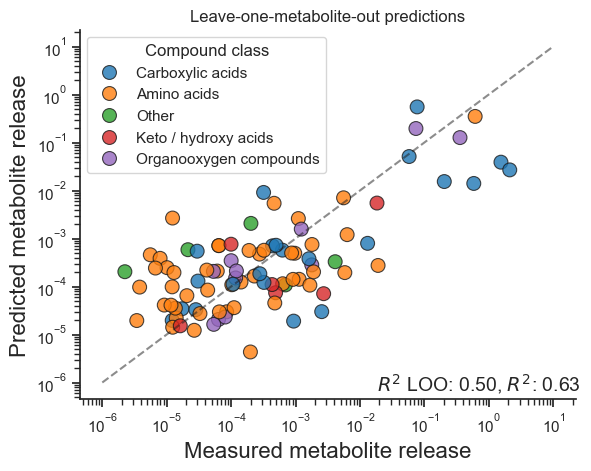

In [33]:

#     ax.scatter(y_vals[i], y_preds[i], label = mname,s = 70, alpha = 0.8, c = 'gray')#, color = cmap40(i))
pred_df = pd.DataFrame()
pred_df['Predicted'] = y_preds2m
pred_df['Measured'] = y_vals2m
pred_df['Measured metabolite release'] = 10**pred_df['Measured']
pred_df['Predicted metabolite release'] = 10**pred_df['Predicted']
pred_df['Metabolite'] = list(lindf3['Metabolite'])
pred_df['Compound class'] = list(lindf3['G'])
ax = sns.scatterplot(data = pred_df, x = 'Measured metabolite release', y = 'Predicted metabolite release', hue = 'Compound class', s = 100,
                     edgecolor='k', palette = 'tab10', alpha = 0.8)

ax.set(xscale="log", yscale="log")
sns.despine()
llog = np.logspace(-6, 1)
ax.plot(llog,llog,c='k',ls = '--', alpha = 0.5)

# plt.legend(ncol = 2, loc = (1.05, 0))
y_preds_arr2 = np.array(y_preds2m)
y_vals_arr2 = np.array(y_vals2m)

SSres = np.sum((y_preds_arr2-y_vals_arr2)**2)
SStot = np.sum((y_vals_arr2-np.mean(y_vals_arr2))**2)
R2 = 1-(SSres/SStot)
print(R2)
# ax.set(xscale="log", yscale="log")

plt.xlabel('Measured metabolite release', fontdict={'size': 16})
plt.ylabel('Predicted metabolite release', fontdict={'size': 16})
plt.title('Leave-one-metabolite-out predictions')
plt.text(0.6,0.02, "$R^2$ LOO: {0:.2f}, $R^2$: {1:.2f}".format(R2, full_res.rsquared), fontdict={'size': 14}, transform=ax.transAxes)
plt.savefig(figure_folder / "LOO_ecoli_metabolite.pdf", bbox_inches='tight')
plt.savefig(figure_folder / "LOO_ecoli_metabolite.png", bbox_inches='tight', dpi=300)

# Leave one out with best model not including metabolite value

In [34]:
cs_list = df_mean_ecoli['Carbon source'].unique()
lindf3 = lindf.copy()
# lindf3.replace({'Phosphorylated sugar':'Other'}, inplace=True)
lindf3.sort_values(by='H', inplace=True)
# phos_param ='G[T.Phosphorylated sugar]'
# xcolumns = ['A', 'B', 'G', 'C']
lindf3['G'] = pd.Categorical(lindf3['G'], categories=lindf3.G.unique())
full_model =  sm.ols(formula="Y ~ A + C + D + E + G", data=lindf3)
full_res = full_model.fit()
y_preds2 = []
y_vals2 = []
for cs in cs_list:
    cidx = lindf3['H']== cs # "Carbon source" is represented by H in this df
    train_model = sm.ols(formula="Y ~ A + C + D + E + G", data=lindf3.loc[~cidx])
    train_res = train_model.fit()
    yp = train_res.predict(lindf3.loc[cidx, ['A', 'C', 'D', 'E', 'G']])
    # test_model = sm.ols(formula="Y ~ A + B + G + C", data=lindf3.loc[cidx])
    # yp = test_model.predict(params=train_res.params, exog = full_model.exog[cidx])
    y_vals2 += list(lindf3.loc[cidx, 'Y'].values)
    y_preds2 += list(yp)
    print(len(y_vals2))
    # y_pred = ols_model.predict(params = res.params, exog = lindf.loc[midx, xcolumns].T)
    # print(m, ols_model.exog.shape,res_full.rsquared_adj, res.rsquared_adj)



18
55
76
92


0.30550484691814306


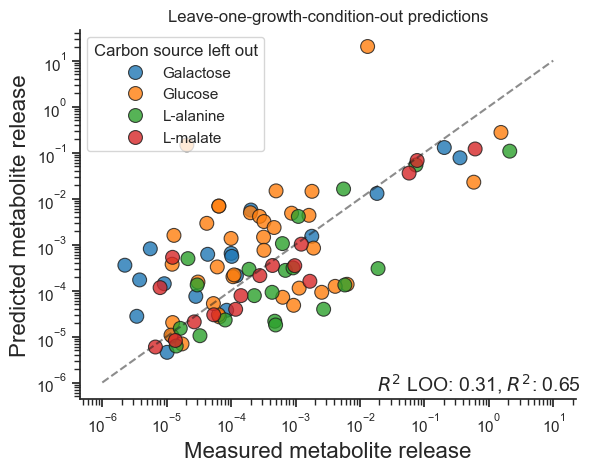

In [35]:
pred_df = pd.DataFrame()
pred_df['Predicted'] = y_preds2
pred_df['Measured'] = y_vals2
pred_df['Carbon source'] = list(lindf3['H'])
# ax = sns.scatterplot(data = pred_df, x = 'Measured', y = 'Predicted', hue = 'Carbon source', s = 100)
pred_df['Measured metabolite release'] = 10**pred_df['Measured']
pred_df['Predicted metabolite release'] = 10**pred_df['Predicted']
ax = sns.scatterplot(data = pred_df, x = 'Measured metabolite release', y = 'Predicted metabolite release', hue = 'Carbon source', s = 100,
                     edgecolor='k', palette = 'tab10', alpha = 0.8)
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_xlim(1,1000)
ax.legend(title="Carbon source left out")
ax.set(xscale="log", yscale="log")
sns.despine()
llog = np.logspace(-6, 1)
ax.plot(llog,llog,c='k',ls = '--', alpha = 0.5)

y_preds_arr2 = np.array(y_preds2)
y_vals_arr2 = np.array(y_vals2)

SSres = np.sum((y_preds_arr2-y_vals_arr2)**2)
SStot = np.sum((y_vals_arr2-np.mean(y_vals_arr2))**2)
R2 = 1-(SSres/SStot)
print(R2)


plt.xlabel('Measured metabolite release', fontdict={'size': 16})
plt.ylabel('Predicted metabolite release', fontdict={'size': 16})
plt.title('Leave-one-growth-condition-out predictions')
plt.text(0.6,0.02, "$R^2$ LOO: {0:.2f}, $R^2$: {1:.2f}".format(R2, full_res.rsquared), fontdict={'size': 14}, transform=ax.transAxes)
plt.savefig(figure_folder / 'LOO_ecoli_condition_no_met_value.pdf', bbox_inches='tight')
plt.show()

In [36]:
mets = lindf3.Metabolite.unique()
full_model =  sm.ols(formula="Y ~ A + C + D + E + G", data=lindf3)
full_res = full_model.fit()
y_preds2m = []
y_vals2m = []
for met in mets:
    cidx = lindf3.Metabolite == met # "Carbon source" is represented by H in this df
    train_model = sm.ols(formula="Y ~ A + C + D + E + G", data=lindf3.loc[~cidx])
    train_res = train_model.fit()
    yp = train_res.predict(lindf3.loc[cidx, ['A', 'C', 'D', 'E', 'G']])
    # test_model = sm.ols(formula="Y ~ A + B + G + C", data=lindf3.loc[cidx])
    # yp = test_model.predict(params=train_res.params, exog = full_model.exog[cidx])
    y_vals2m += list(lindf3.loc[cidx, 'Y'].values)
    y_preds2m += list(yp)
    # print(len(y_vals2m))
    # y_pred = ols_model.predict(params = res.params, exog = lindf.loc[midx, xcolumns].T)
    # print(m, ols_model.exog.shape,res_full.rsquared_adj, res.rsquared_adj)
print(f'Condition number: {np.linalg.cond(full_model.exog)}')


Condition number: 1765.132415427443


0.49574687963019404


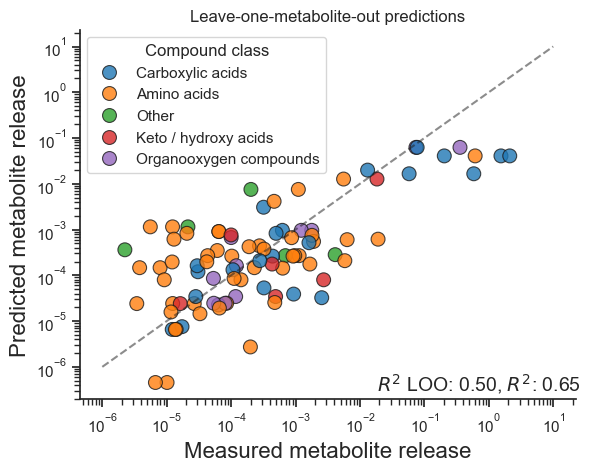

In [37]:

#     ax.scatter(y_vals[i], y_preds[i], label = mname,s = 70, alpha = 0.8, c = 'gray')#, color = cmap40(i))
pred_df = pd.DataFrame()
pred_df['Predicted'] = y_preds2m
pred_df['Measured'] = y_vals2m
pred_df['Measured metabolite release'] = 10**pred_df['Measured']
pred_df['Predicted metabolite release'] = 10**pred_df['Predicted']
pred_df['Metabolite'] = list(lindf3['Metabolite'])
pred_df['Compound class'] = list(lindf3['G'])
ax = sns.scatterplot(data = pred_df, x = 'Measured metabolite release', y = 'Predicted metabolite release', hue = 'Compound class', s = 100,
                     edgecolor='k', palette = 'tab10', alpha = 0.8)

ax.set(xscale="log", yscale="log")
sns.despine()
llog = np.logspace(-6, 1)
ax.plot(llog,llog,c='k',ls = '--', alpha = 0.5)

# plt.legend(ncol = 2, loc = (1.05, 0))
y_preds_arr2 = np.array(y_preds2m)
y_vals_arr2 = np.array(y_vals2m)

SSres = np.sum((y_preds_arr2-y_vals_arr2)**2)
SStot = np.sum((y_vals_arr2-np.mean(y_vals_arr2))**2)
R2 = 1-(SSres/SStot)
print(R2)
# ax.set(xscale="log", yscale="log")

plt.xlabel('Measured metabolite release', fontdict={'size': 16})
plt.ylabel('Predicted metabolite release', fontdict={'size': 16})
plt.title('Leave-one-metabolite-out predictions')
plt.text(0.6,0.02, "$R^2$ LOO: {0:.2f}, $R^2$: {1:.2f}".format(R2, full_res.rsquared), fontdict={'size': 14}, transform=ax.transAxes)
plt.savefig(figure_folder / "LOO_ecoli_metabolite_not_met_value.pdf", bbox_inches='tight')
plt.savefig(figure_folder / "LOO_ecoli_metabolite_not_met_value.png", bbox_inches='tight', dpi=300)

# Statistical comparison of LOO with or w/o metabolite value

In [38]:
top_n = 20
top_n_models = adjusted_r2_df.loc[adjusted_r2_df['Contains B']].head(top_n)['Combination'].apply(lambda x: ' + '.join(x))
top_n_models_no_B = adjusted_r2_df.loc[~adjusted_r2_df['Contains B']].head(top_n)['Combination'].apply(lambda x: ' + '.join(x))

In [39]:
# Create DataFrames with a column indicating the group
df_with_b = pd.DataFrame({
    'Model': top_n_models.values,
    'Type': 'With B'
})
df_without_b = pd.DataFrame({
    'Model': top_n_models_no_B.values,
    'Type': 'Without B'
})

# Concatenate into long-form
top_models_long = pd.concat([df_with_b, df_without_b], ignore_index=False)
top_models_long.reset_index(inplace=True)
print(top_models_long)

    index                      Model       Type
0       0              A + B + C + G     With B
1       1          A + B + C + D + G     With B
2       2          A + B + C + G + T     With B
3       3      A + B + C + D + E + G     With B
4       4          A + B + C + G + R     With B
5       5      A + B + C + E + G + T     With B
6       6      A + B + C + D + G + U     With B
7       7      A + B + C + G + T + U     With B
8       8          A + B + C + G + H     With B
9       9          A + B + C + G + U     With B
10     10          A + B + C + G + S     With B
11     11  A + B + E + G + S + T + U     With B
12     12  A + B + C + D + E + G + S     With B
13     13      A + B + C + D + G + T     With B
14     14          A + B + C + F + G     With B
15     15          A + B + C + E + G     With B
16     16  A + B + C + E + G + S + T     With B
17     17      A + B + C + D + F + G     With B
18     18      A + B + C + D + G + S     With B
19     19      A + B + C + D + G + H    

In [40]:
cs_list = df_mean_ecoli['Carbon source'].unique()
lindf3 = lindf.copy()
lindf3.sort_values(by='H', inplace=True)
lindf3['G'] = pd.Categorical(lindf3['G'], categories=lindf3.G.unique())
lindf3['H'] = pd.Categorical(lindf3['H'], categories=lindf3.H.unique())

lin_model_data = []
for _, row in top_models_long.iterrows():
    # print(row)
    model = row['Model']
    withB = row['Type']
    # full_model =  sm.ols(formula=f"Y ~ {model}", data=lindf3)
    # full_res = full_model.fit()
    full_res = np.nan
    y_preds2 = []
    y_vals2 = []
    for cs in cs_list:
        cidx = lindf3['H']== cs 
        train_model = sm.ols(formula=f"Y ~ {model}", data=lindf3.loc[~cidx])
        train_res = train_model.fit()
        factors = [x.strip() for x in model.split('+')]
        yp = train_res.predict(lindf3.loc[cidx, factors])
        y_vals2 += list(lindf3.loc[cidx, 'Y'].values)
        y_preds2 += list(yp)
    # plt.legend(ncol = 2, loc = (1.05, 0))
    y_preds_arr2 = np.array(y_preds2)
    y_vals_arr2 = np.array(y_vals2)

    SSres = np.sum((y_preds_arr2-y_vals_arr2)**2)
    SStot = np.sum((y_vals_arr2-np.mean(y_vals_arr2))**2)
    R2 = 1-(SSres/SStot)

    lin_model_data.append({
        'Model': model,
        'R2': R2,
        'With B': withB,
        'Rank': row['index'] + 1 }
    )
lin_model_df = pd.DataFrame(lin_model_data)
        


<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
/var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/ipykernel_42399/2895766437.py:22: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title("Top 20 linear models with and without $\log_{10}$(Met. value)")
/var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/ipykernel_42399/2895766437.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['With', 'Without'])


0.002557631011563264


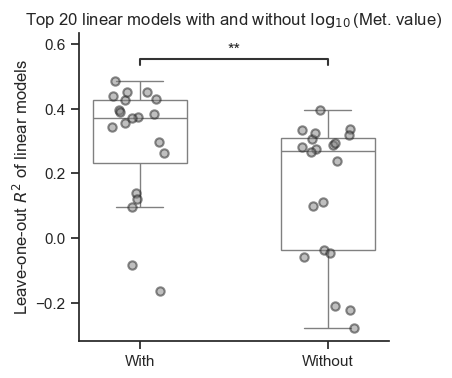

In [41]:
fig, ax = plt.subplots(figsize=(4, 4))

l = sns.boxplot(data=lin_model_df, y='R2', x='With B', width=0.5, fliersize=0, showfliers=False, 
            linewidth= 1, color = 'w', linecolor='grey')
sns.stripplot(data=lin_model_df, y='R2', x='With B', size=6, alpha=0.5, jitter=0.15, ax=l,
              edgecolor='k', linewidth=1.5, color = 'grey')


x1 = lin_model_df.loc[lin_model_df['With B'] == 'With B', 'R2']
x2 = lin_model_df.loc[lin_model_df['With B'] == 'Without B', 'R2']
stat, p_value = st.mannwhitneyu(x1, x2, alternative='greater')

# Add statannotations
pairs = [("With B", "Without B")]
annotator = Annotator(ax, pairs, data=lin_model_df, x="With B", y="R2")
annotator.configure(text_format='star', loc='inside', verbose=0)
annotator.set_pvalues_and_annotate(pvalues=[p_value])
print(p_value)
sns.despine()
ax.set_ylabel(r"Leave-one-out $R^2$ of linear models")
ax.set_xlabel("")
ax.set_title("Top 20 linear models with and without $\log_{10}$(Met. value)")
ax.set_xticklabels(['With', 'Without'])
plt.savefig(figure_folder / "LOO_linear_models_with_without_met_value.pdf", bbox_inches='tight')
plt.savefig(figure_folder / "LOO_linear_models_with_without_met_value.png", bbox_inches='tight', dpi=300)


In [42]:

print(stat, p_value)

304.0 0.002557631011563264


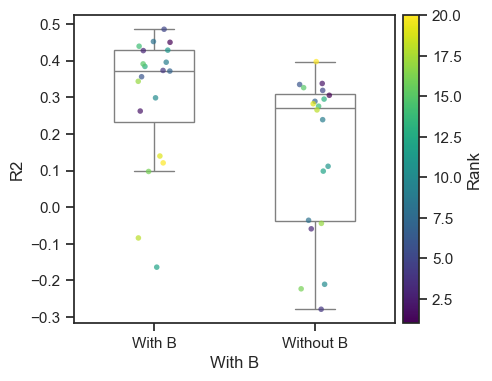

In [43]:
import matplotlib as mpl


fig, ax = plt.subplots(figsize=(5, 4))

l = sns.boxplot(data=lin_model_df, y='R2', x='With B', width=0.5, fliersize=0, showfliers=False, 
            linewidth= 1, color = 'w', linecolor='grey')
# sns.stripplot(data=lin_model_df, y='R2', x='With B', hue = 'Rank', palette='viridis', size=6, alpha=0.5, jitter=True, ax=l,
#               edgecolor='k', linewidth=0.5)

# Normalize the rank for the colormap
norm = mpl.colors.Normalize(vmin=lin_model_df['Rank'].min(), vmax=lin_model_df['Rank'].max())
scam = mpl.cm.ScalarMappable(cmap="viridis", norm=norm)
scam.set_array([])

# Plot stripplot with continuous color mapping
sns.stripplot(
    data=lin_model_df, y='R2', x='With B', hue='Rank', palette="viridis",
    size=4, alpha=0.7, jitter=True, ax=ax, dodge=False, legend=False
)

# Add colorbar
cbar = plt.colorbar(scam, ax=ax, pad=0.02)
cbar.set_label('Rank')

In [44]:
short_cclass = {
'Organooxygen compounds': 'OC',
 'Keto / hydroxy acids': 'KA',
 'Carboxylic acids': 'CA',
 'Other': 'O',
 'Amino acids':'AA'
}

log10(Metabolite value [gDW/mmol])
Rotatable Bond Count
Compound class
F-statistic: 23.904805281901062
P-value: 8.346181484964165e-05
                        Amino acids  Carboxylic acids  Keto / hydroxy acids  \
Amino acids                1.000000          0.000009              0.005123   
Carboxylic acids           0.000009          1.000000              1.000000   
Keto / hydroxy acids       0.005123          1.000000              1.000000   
Organooxygen compounds     0.035651          0.267938              0.376235   
Other                      0.820366          0.005996              0.033984   

                        Organooxygen compounds     Other  
Amino acids                           0.035651  0.820366  
Carboxylic acids                      0.267938  0.005996  
Keto / hydroxy acids                  0.376235  0.033984  
Organooxygen compounds                1.000000  0.186680  
Other                                 0.186680  1.000000  
p-value annotation legend:
      ns: 

/var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/ipykernel_42399/2386303828.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([short_cclass[x.get_text()] for x in ax.get_xticklabels()],size = 11)


log P
Hydrogen Bond Donor Count
Mol weight [g/mol]
Topological Polar Surface Area
Hydrogen Bond Acceptor Count
log10(Turnover [mmol/gDW/h])
Charge
Carbon source
F-statistic: 6.485648618863195
P-value: 0.09023020847639858
           Galactose   Glucose  L-alanine  L-malate
Galactose   1.000000  0.019011   0.011920  0.073164
Glucose     0.019011  1.000000   0.621161  0.731416
L-alanine   0.011920  0.621161   1.000000  0.568693
L-malate    0.073164  0.731416   0.568693  1.000000
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Galactose vs. Glucose: Custom statistical test, P_val:1.901e-02
Galactose vs. L-alanine: Custom statistical test, P_val:1.192e-02


/var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/ipykernel_42399/2386303828.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x.get_text() for x in ax.get_xticklabels()],size = 11, rotation = 45)


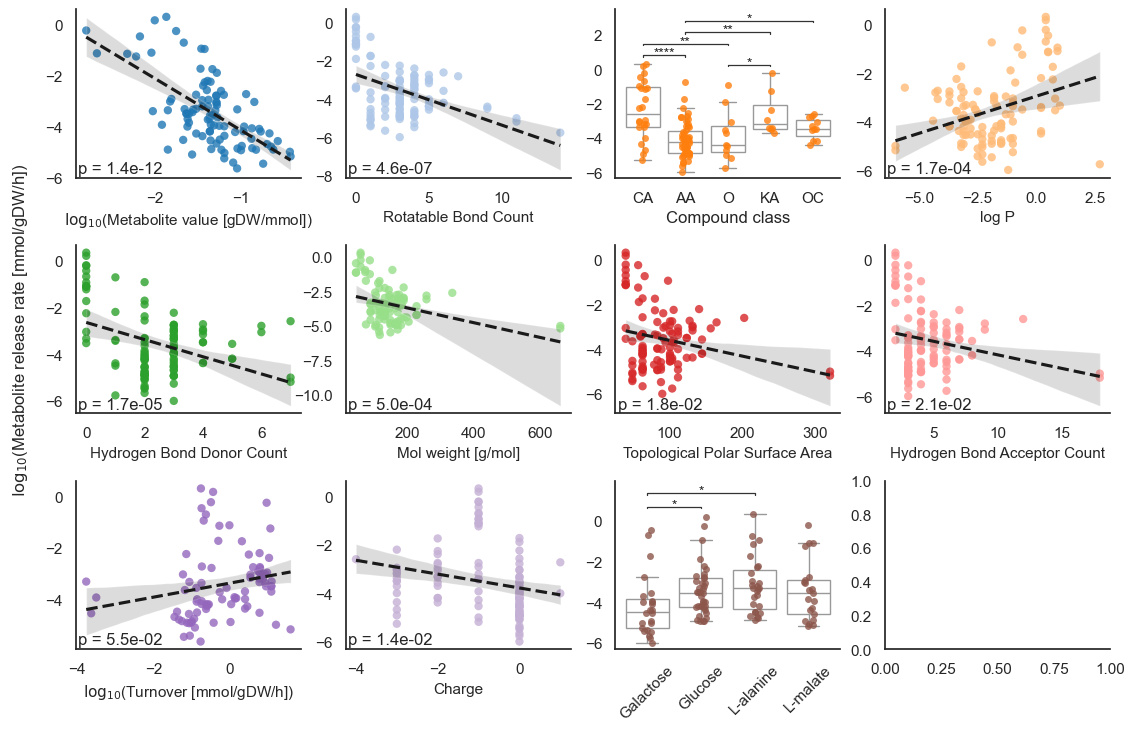

In [56]:

fig, axes = plt.subplots(3,4, figsize = (11,8))#,sharey=True)
axes = axes.flatten()

cmap = plt.get_cmap('tab20')
color_dict = {xaxis:cmap(i) for i, xaxis in enumerate(df_r2.Parameter)}
# bar_colors = [color_dict[x] for x in df_r2.Parameter.values]

number_cols = df_mean.select_dtypes(include='number')
plot_parameters = [x for x in df_r2.Parameter if not '+' in x]

for i, xaxis in enumerate(plot_parameters):
    if i >= 12:
        break
    ax = axes[i]
        
    print(xaxis)
    color = color_dict[xaxis]
    idx = (df_mean.Species=='E. coli')&(df_mean.Dataset != 'Vila-23')&df_mean[[xaxis,'log10(Rate [mmol/gDW/h])']].notna().all(axis = 1)
    if xaxis in ['Compound class', 'Carbon source']:
        # Statistical test
        data = []
        compound_classes = df_mean.loc[idx, xaxis].unique()
        for c1 in compound_classes:
            dfmc = df_mean.loc[idx&(df_mean_ecoli[xaxis] == c1)]
            data.append(dfmc['log10(Rate [mmol/gDW/h])'].values)
        # Perform one-way ANOVA
        f_stat, p_value = st.kruskal(*data)

        # Print the results
        print(f"F-statistic: {f_stat}")
        print(f"P-value: {p_value}")
        
        # Posthoc analyses
        posthoc_results = posthoc_conover(df_mean.loc[idx], val_col='log10(Rate [mmol/gDW/h])', group_col=xaxis, p_adjust='fdr_bh')#'bonferroni'
        print(posthoc_results)

        # Define pairs for comparisons
        pairs = [(group1, group2) for j, group1 in enumerate(compound_classes) for group2 in compound_classes[j + 1:]]
        p_values = [posthoc_results.at[pair[0], pair[1]]for pair in pairs]
        
        
        sns.boxplot(data = df_mean.loc[idx], x = xaxis, y = 'log10(Rate [mmol/gDW/h])', color='w', 
                    ax = ax, fliersize=0)
        sns.stripplot(data = df_mean.loc[idx], x = xaxis, y = 'log10(Rate [mmol/gDW/h])', 
                      color=color, ax = ax, alpha = 0.8)
        
        # Add statistical annotations
        annotator = Annotator(ax, pairs, data=df_mean.loc[idx], x=xaxis, y='log10(Rate [mmol/gDW/h])')
        annotator.configure(
            text_format="star",
            loc="inside",
            hide_non_significant=True,
            text_offset = -3,  # Adjust the text offset
            fontsize=10,
            line_width = 0.9,
            # use_fixed_offset=True,
            
            # line_offset_to_group=0.01,  # Reduce the vertical offset of the lines
            line_height=0.01           # Reduce the height of the brackets
        )
        
        annotator.set_pvalues_and_annotate(p_values)
        if xaxis == 'Compound class':
            ax.set_xticklabels([short_cclass[x.get_text()] for x in ax.get_xticklabels()],size = 11)
        else:
            ax.set_xticklabels([x.get_text() for x in ax.get_xticklabels()],size = 11, rotation = 45)
            ax.set_xlabel('')
    else:
        sns.regplot(data = df_mean.loc[idx], x = xaxis, y = 'log10(Rate [mmol/gDW/h])', 
                line_kws={'color': 'k', 'ls': '--'}, scatter_kws={'color': color, 'edgecolor': 'none', 'alpha':0.8}, ax = ax)
        slope, intercept, rvalue, pvalue, _ = linregress(df_mean.loc[idx, xaxis].values, df_mean.loc[idx, 'log10(Rate [mmol/gDW/h])'].values)
        # ax.annotate(fr'$\rho$ = {rvalue:.2f}', (0.6, 0.9), xycoords = 'axes fraction')
        ax.annotate(fr'p = {pvalue:.1e}', (0.01, 0.01), xycoords = 'axes fraction', ha = 'left', va = 'bottom')
        ax.set_xlabel(ax.get_xlabel().replace('log10', r'$\rm{log_{10}}$'),size = 11)
    ax.set_ylabel("")

    
    # ax.annotate(fr'$R^2$ = {rvalue**2:.2f}', (0.62, 0.7), xycoords = 'axes fraction')
    
fig.supylabel(r'$\rm{log_{10}}$(Metabolite release rate [mmol/gDW/h])', size = 12)
# axes[-2].remove()
# axes[-1].remove()
# plt.tight_layout()
sns.despine()
plt.subplots_adjust(left = 0.08, wspace=0.2, hspace=0.4, right = 1.02, top = 0.9, bottom = 0.1)
plt.savefig(figure_folder/'correlations_different_factors_ecoli_standards.pdf', bbox_inches='tight')
# corr_data = df_mean.loc[df_mean.Species=='E. coli',['log10(Metabolite value [gDW/mmol])', 'log10(Rate [mmol/gDW/h])']]
# corr_data = corr_data.loc[~corr_data.isna().any(axis = 1)]

## Add supplemental figure with metabolite values for the different classes

F-statistic: 30.46086526272876
P-value: 3.943095063532021e-06
                        Amino acids  Carboxylic acids  Keto / hydroxy acids  \
Amino acids                1.000000          0.000011              0.000022   
Carboxylic acids           0.000011          1.000000              0.281891   
Keto / hydroxy acids       0.000022          0.281891              1.000000   
Organooxygen compounds     0.089107          0.089107              0.031497   
Other                      0.281891          0.000649              0.000237   

                        Organooxygen compounds     Other  
Amino acids                           0.089107  0.281891  
Carboxylic acids                      0.089107  0.000649  
Keto / hydroxy acids                  0.031497  0.000237  
Organooxygen compounds                1.000000  0.057057  
Other                                 0.057057  1.000000  
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.

/var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/ipykernel_42399/9510013.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([short_cclass[x.get_text()] for x in ax.get_xticklabels()],size = 11)


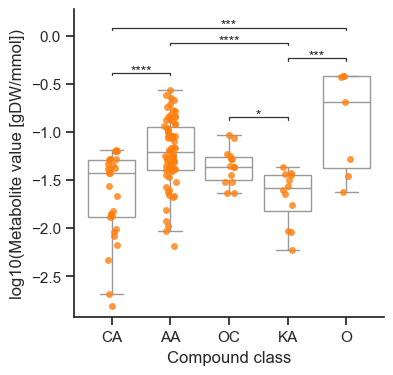

In [46]:

fig, ax = plt.subplots(1, figsize = (4,4))#,sharey=True)

cmap = plt.get_cmap('tab20')
color_dict = {xaxis:cmap(i) for i, xaxis in enumerate(df_r2.Parameter)}
# color = color_dict[xaxis]
xaxis = 'Compound class'
yaxis = 'log10(Metabolite value [gDW/mmol])'
idx = (df_mean.Species=='E. coli')&(df_mean.Dataset != 'Vila-23')&df_mean[[xaxis,yaxis]].notna().all(axis = 1)
# Statistical test
data = []
compound_classes = df_mean.loc[idx, xaxis].unique()
for c1 in compound_classes:
    dfmc = df_mean.loc[idx&(df_mean_ecoli[xaxis] == c1)]
    data.append(dfmc[yaxis].values)
# Perform one-way ANOVA
f_stat, p_value = st.kruskal(*data)

# Print the results
print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

# Posthoc analyses
posthoc_results = posthoc_conover(df_mean.loc[idx], val_col=yaxis, group_col=xaxis, p_adjust='fdr_bh')#'bonferroni'
print(posthoc_results)

# Define pairs for comparisons
pairs = [(group1, group2) for j, group1 in enumerate(compound_classes) for group2 in compound_classes[j + 1:]]
p_values = [posthoc_results.at[pair[0], pair[1]]for pair in pairs]
    
    
sns.boxplot(data = df_mean.loc[idx], x = xaxis, y = yaxis, color='w', 
            ax = ax, fliersize=0, 
            # order = ['Carboxylic acids', 'Amino acids', 'Other', 'Keto / hydroxy acids', 'Organooxygen compounds']
            )
sns.stripplot(data = df_mean.loc[idx], x = xaxis, y = yaxis, 
                color=cmap(2), ax = ax, alpha = 0.8)
    
# Add statistical annotations
annotator = Annotator(ax, pairs, data=df_mean.loc[idx], x=xaxis, y=yaxis)
annotator.configure(
    text_format="star",
    loc="inside",
    hide_non_significant=True,
    text_offset = -3,  # Adjust the text offset
    fontsize=10,
    line_width = 0.9,
    # use_fixed_offset=True,
    
    # line_offset_to_group=0.01,  # Reduce the vertical offset of the lines
    line_height=0.01           # Reduce the height of the brackets
)

annotator.set_pvalues_and_annotate(p_values)
if xaxis == 'Compound class':
    ax.set_xticklabels([short_cclass[x.get_text()] for x in ax.get_xticklabels()],size = 11)
else:
    ax.set_xticklabels([x.get_text() for x in ax.get_xticklabels()],size = 11, rotation = 45)
    ax.set_xlabel('')
    
# fig.supylabel(r'$\rm{log_{10}}$(Metabolite release rate [mmol/gDW/h])', size = 12)
sns.despine()
# plt.subplots_adjust(left = 0.08, wspace=0.2, hspace=0.4, right = 1.02, top = 0.9, bottom = 0.1)
plt.savefig(figure_folder/'metabolite_value_different_classes.pdf', bbox_inches='tight')
plt.savefig(figure_folder/'metabolite_value_different_classes.png', bbox_inches='tight', dpi = 300)


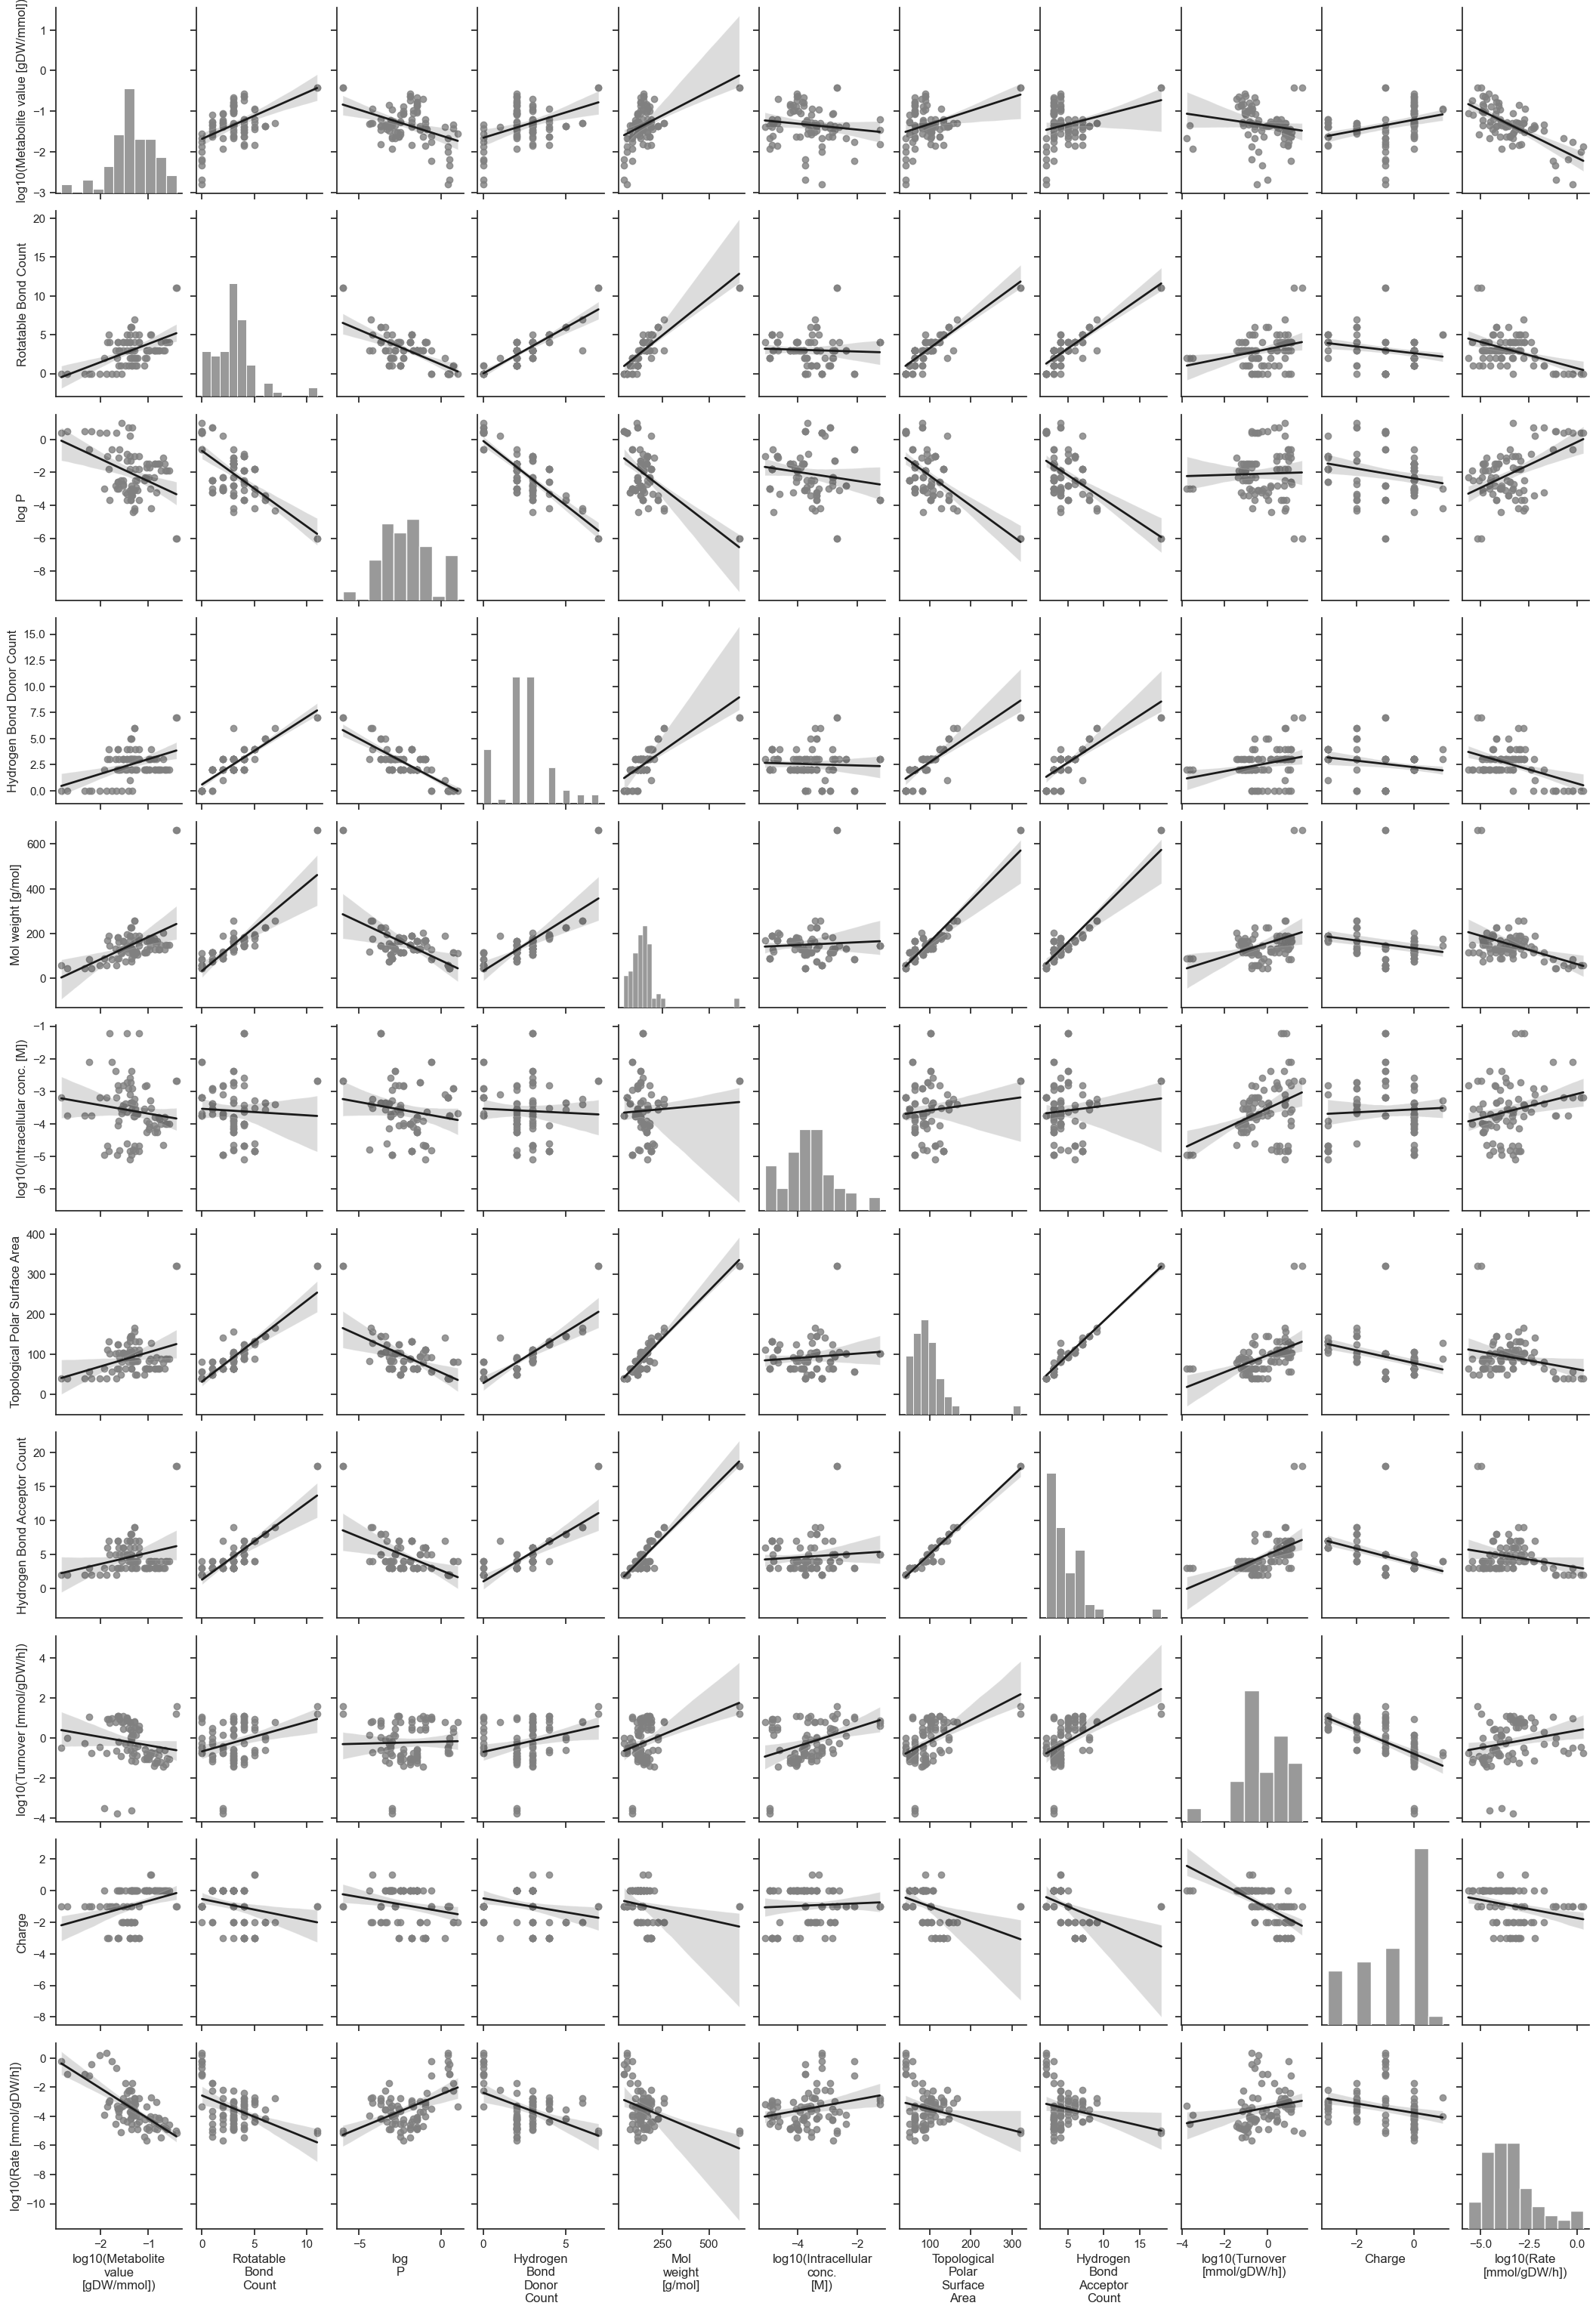

In [47]:
# Filter numeric columns from plot_parameters
numeric_plot_parameters = df_mean[plot_parameters].select_dtypes(include=['float64', 'int64']).columns.tolist() + ['log10(Rate [mmol/gDW/h])']

# Filter the DataFrame to exclude NaN values for the selected numeric parameters
idx = (df_mean.Species == 'E. coli') & (df_mean.Dataset != 'Vila-23') & df_mean[numeric_plot_parameters].notna().all(axis=1)

# Create the pairplot with regression for numeric parameters
pp = sns.pairplot(df_mean.loc[idx], vars=numeric_plot_parameters, kind='reg', aspect=0.7,
             plot_kws={
                "scatter_kws": {"color": "gray", "alpha": 0.8},  # Set scatter points to gray
                "line_kws": {"color": "k", "lw": 2},          # Set regression line to gray
                },
                 diag_kws={
                  "color": "gray",  # Set histogram bars to gray
                  "alpha": 0.8      # Adjust transparency of histogram bars
               })
# Wrap long x-axis labels into two lines
for ax in pp.axes[-1, :]:  # Iterate over the bottom row of axes
    ax.set_xlabel(ax.get_xlabel().replace(' ', '\n'), fontsize=12)  # Replace spaces with newlines
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)
plt.subplots_adjust(top=1.1, right = 1.1)
plt.savefig(figure_folder/'pairplot_ecoli_standards.pdf', bbox_inches='tight')

## 

In [48]:
posthoc_results.at['Amino acids', 'Keto / hydroxy acids']

np.float64(2.1510737346384534e-05)

## Supplemental linear models for each dataset / species

In [49]:
df_lm_dict = {}
for d in df_mean.Dataset.unique():
    dfd = df_mean.loc[df_mean.Dataset==d]
    for s in dfd.Species.unique():
        print(s)
        if s == 'C. glutamicum':
            continue
        dfs = dfd.loc[dfd.Species==s].copy()
        dfs.fillna({'log10(Turnover [mmol/gDW/h])':-4}, inplace = True)
        # Remove all nan columns
        dfs = dfs.loc[:, ~dfs.isna().all()]

        # Remove nan rows
        # dfs.dropna(inplace=True)
        
        lindfd = pd.DataFrame()
        for key, col_name in key_to_col.items():
            try:
                lindfd[key] = dfs[col_name]
            except KeyError:
                pass

        var_explained = {}
        for key, col_name in key_to_col.items():
            if col_name == 'log10(Rate [mmol/gDW/h])':
                continue
            elif (col_name=='log10(Intracellular conc. [M])') and (s != 'E. coli'):
                continue
            if col_name not in dfd.columns:
                continue
            res = sm.ols(formula=f"Y ~ {key}", data=lindfd).fit(missing='drop')
            var_explained[col_name] = res.rsquared
            print(key, col_name, f'R2: {res.rsquared:.2f}')
            # print(res.summary2())


        # var_explained['log10(MV) + log10(IC) + Charge + C class'] = res.rsquared
        # print(var_explained)
        df_r2 = pd.DataFrame(var_explained, index = ['Variability explained']).T.reset_index(names = 'Parameter').sort_values(by= 'Variability explained', ascending = False)
        df_lm_dict[f'{d}: {s}'] = df_r2
    

P. putida
B log10(Metabolite value [gDW/mmol]) R2: 0.45
C Charge R2: 0.01
D Mol weight [g/mol] R2: 0.10
E log P R2: 0.00
F log10(Turnover [mmol/gDW/h]) R2: 0.02
R Rotatable Bond Count R2: 0.06
S Hydrogen Bond Donor Count R2: 0.02
T Hydrogen Bond Acceptor Count R2: 0.09
U Topological Polar Surface Area R2: 0.11
G Compound class R2: 0.06
H Carbon source R2: 0.28
Pseudomonas
B log10(Metabolite value [gDW/mmol]) R2: 0.20
C Charge R2: 0.00
D Mol weight [g/mol] R2: 0.15
E log P R2: 0.05
F log10(Turnover [mmol/gDW/h]) R2: 0.00
R Rotatable Bond Count R2: 0.12
S Hydrogen Bond Donor Count R2: 0.12
T Hydrogen Bond Acceptor Count R2: 0.13
U Topological Polar Surface Area R2: 0.18
G Compound class R2: 0.10
H Carbon source R2: 0.17
E. coli
A log10(Intracellular conc. [M]) R2: 0.06
B log10(Metabolite value [gDW/mmol]) R2: 0.40
C Charge R2: 0.07
D Mol weight [g/mol] R2: 0.20
E log P R2: 0.13
F log10(Turnover [mmol/gDW/h]) R2: 0.04
R Rotatable Bond Count R2: 0.32
S Hydrogen Bond Donor Count R2: 0.28
T 

In [50]:
# Combine all DataFrames in df_lm_dict into a single DataFrame
big_df_r2 = pd.concat(df_lm_dict, names=['Dataset: Species/strain']).reset_index()

# Rename columns for clarity
big_df_r2.rename(columns={'level_1': 'Index'}, inplace=True)

# Display the resulting DataFrame
big_df_r2

,Dataset: Species/strain,Index,Parameter,Variability explained
0,Vila-23: P. putida,0,log10(Metabolite value [gDW/mmol]),0.445027
1,Vila-23: P. putida,10,Carbon source,0.276416
2,Vila-23: P. putida,8,Topological Polar Surface Area,0.109325
3,Vila-23: P. putida,2,Mol weight [g/mol],0.099002
4,Vila-23: P. putida,7,Hydrogen Bond Acceptor Count,0.086329
...,...,...,...,...
86,Paczia-12: S. cerevisiae,8,Topological Polar Surface Area,0.219908
87,Paczia-12: S. cerevisiae,7,Hydrogen Bond Acceptor Count,0.151215
88,Paczia-12: S. cerevisiae,4,log10(Turnover [mmol/gDW/h]),0.029218
89,Paczia-12: S. cerevisiae,1,Charge,0.002670


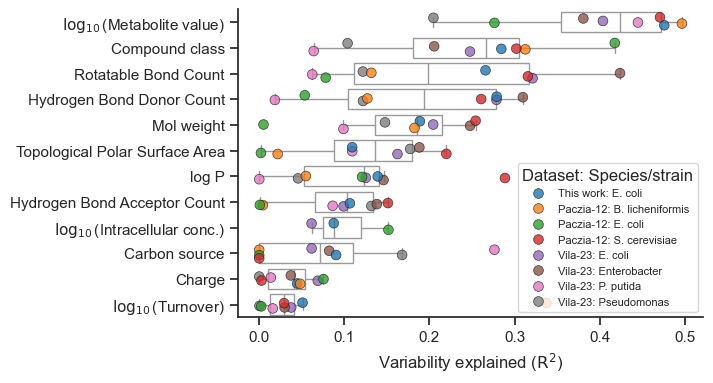

In [51]:
# Calculate the median of 'Variability explained' for each 'Parameter'

# Reorder the DataFrame based on the median order
big_df_r2['Parameter'] = pd.Categorical(big_df_r2['Parameter'])
big_df_r2['Parameter name'] = big_df_r2['Parameter'].str.replace(r' \[.*?\]', '', regex=True)
big_df_r2['Parameter name'] = big_df_r2['Parameter name'].str.replace('log10', r'$\log_{10}$', regex=False)
big_df_r2['Dataset: Species/strain'] = big_df_r2['Dataset: Species/strain'].str.replace('SINTEF-23', 'This work')
median_order = big_df_r2.groupby('Parameter name')['Variability explained'].median().sort_values(ascending=False)

dataset_order = ['This work: E. coli',
                'Paczia-12: B. licheniformis',
                'Paczia-12: E. coli',
                'Paczia-12: S. cerevisiae',
                'Vila-23: E. coli',
                'Vila-23: Enterobacter', 
                'Vila-23: P. putida', 
                'Vila-23: Pseudomonas' ]
# Create the plot
fig, ax = plt.subplots(1, figsize=(6, 4))
ax = sns.boxplot(data=big_df_r2, x='Variability explained', y='Parameter name',
                 color='w', fliersize=0, order=median_order.index)
sns.stripplot(data=big_df_r2, x='Variability explained', y='Parameter name', hue='Dataset: Species/strain',
              hue_order= dataset_order,
              palette='tab10', legend=True, ax=ax, jitter=0.2, s=7, alpha=0.8, edgecolor='k', linewidth=0.5)

# Format the y-axis labels
# formatted_labels = [label.replace('log10', r'$\log_{10}$') for label in median_order.index]
# ax.set_yticklabels(formatted_labels, fontsize=10)

# Adjust legend
sns.despine()
ax.set_xlabel(r"Variability explained ($\rm{R^2}$)")

sns.move_legend(ax, "lower right", bbox_to_anchor=(1, 0), title='Dataset: Species/strain', fontsize=8)
plt.ylabel('')
# plt.tight_layout()
plt.savefig(figure_folder/'variability_explained_all_dataset.pdf', bbox_inches='tight')
# posthoc_conover(big_df_r2, val_col='Variability explained', group_col='Parameter name', p_adjust='fdr_bh')

In [52]:
big_df_r2['Dataset: Species/strain'].unique()

array(['Vila-23: P. putida', 'Vila-23: Pseudomonas', 'Vila-23: E. coli',
       'Vila-23: Enterobacter', 'This work: E. coli',
       'Paczia-12: B. licheniformis', 'Paczia-12: E. coli',
       'Paczia-12: S. cerevisiae'], dtype=object)

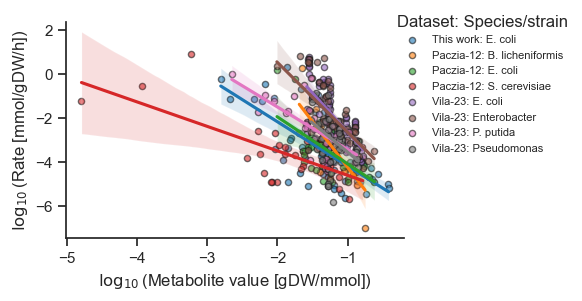

In [53]:
# Combine 'Dataset' and 'Species' into a single column
df_mean['Hue'] = df_mean['Dataset'] + ": " + df_mean['Species']
df_mean['Hue'] = df_mean['Hue'].str.replace('SINTEF-23', 'This work')

# Create the plot with the combined column as hue
g = sns.lmplot(
    data=df_mean.loc[df_mean.Species != 'C. glutamicum'],
    x='log10(Metabolite value [gDW/mmol])',
    y='log10(Rate [mmol/gDW/h])',
    hue='Hue',  # Use the combined column for hue
    hue_order=dataset_order,
    palette='tab10',
    height=3,
    aspect=1.5,
    scatter_kws={'s': 20, 'edgecolor': 'k', 'alpha': 0.6},
)
sns.move_legend(g, "upper right", bbox_to_anchor=(0.9, 1), title='Dataset: Species/strain', fontsize=8)
plt.xlabel(r'$\log_{10}$(Metabolite value [gDW/mmol])')
plt.ylabel(r'$\log_{10}$(Rate [mmol/gDW/h])')
plt.savefig(figure_folder / 'MV_vs_rate_all_species.pdf', bbox_inches='tight')

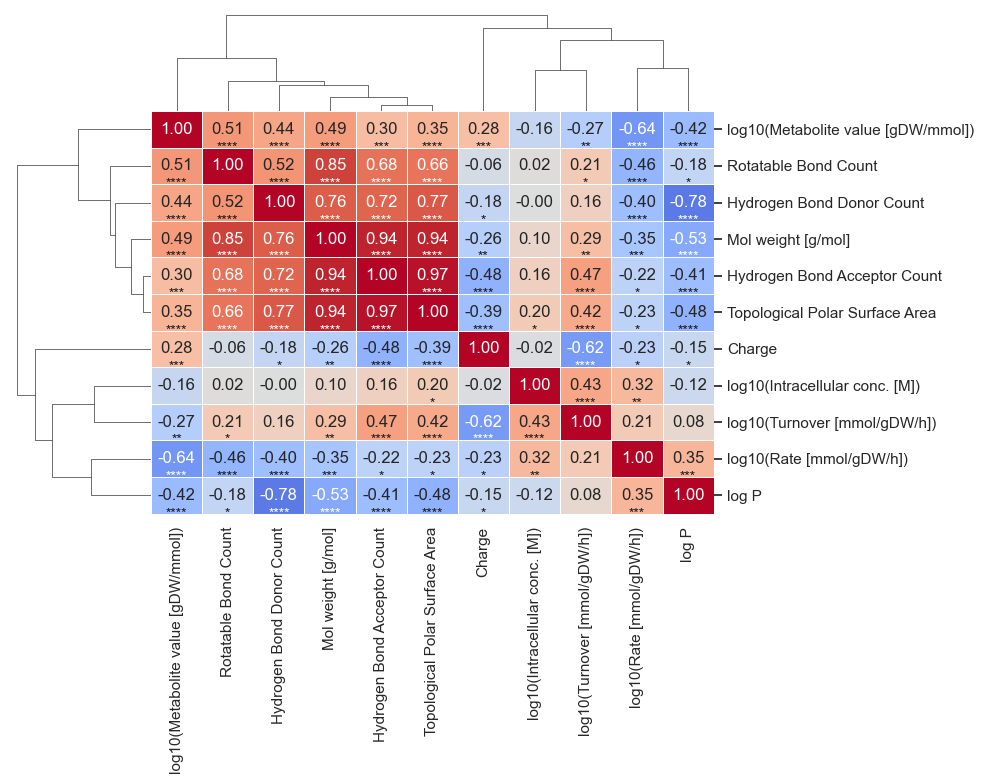

In [54]:

df_filtered = df_mean.loc[((df_mean['Species'] == 'E. coli')&(df_mean.Dataset!='Vila-23')), [x for x in key_to_col.values()]]

# Select only numeric columns for correlation
numeric_cols = df_filtered.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix and p-values
correlation_matrix = numeric_cols.corr()
p_values = numeric_cols.corr(method=lambda x, y: st.pearsonr(x, y)[1])  # Compute p-values for correlations

# Create a mask for significant correlations (e.g., p < 0.05)
significance_mask = p_values < 0.05

# Create the clustermap
sns.set_theme(style="white")
clustermap = sns.clustermap(
    correlation_matrix,
    cmap="coolwarm",
    center=0,
    annot=True,  # Add correlation values to the heatmap
    fmt=".2f",   # Format for annotations
    linewidths=0.5,
    figsize=(10, 8),
    cbar_pos=None
)

# Get the reordered indices from the clustermap
reordered_rows = clustermap.dendrogram_row.reordered_ind
reordered_cols = clustermap.dendrogram_col.reordered_ind

# Reorder the correlation matrix and p-values to match the clustermap
reordered_corr = correlation_matrix.iloc[reordered_rows, reordered_cols]
reordered_pvals = p_values.iloc[reordered_rows, reordered_cols]

# Add stars for significant correlations
for i in range(reordered_corr.shape[0]):
    for j in range(reordered_corr.shape[1]):
        # print(i, j, p_values.iloc[i, j]) 
        if i == j:
            continue
        if reordered_pvals.iloc[i, j] > 0.05:  # Adjust the threshold as needed
            text = ''
        elif 0.01 < reordered_pvals.iloc[i, j] < 0.05:
            text = '*'
        elif 0.001 < reordered_pvals.iloc[i, j] < 0.01:
            text = '**'
        elif 0.0001 < reordered_pvals.iloc[i, j] < 0.001:
            text = '***'
        else:
            text = '****'

        value = reordered_corr.iloc[i, j]

        # Determine the color of the annotation based on the correlation value
        if np.abs(value) > 0.5282:
            color = 'w'
        else:
            color = 'k'

        # Add the annotation at the correct position
        clustermap.ax_heatmap.text(
            j+0.5, i+1, text, color=color, ha='center', va='center', fontsize=10
        )

plt.savefig(figure_folder / 'clustermap_correlations_with_significance_ecoli_std.pdf', bbox_inches='tight')
plt.savefig(figure_folder / 'clustermap_correlations_with_significance_ecoli_std.png', bbox_inches='tight', dpi=300)
# Show the plot
plt.show()

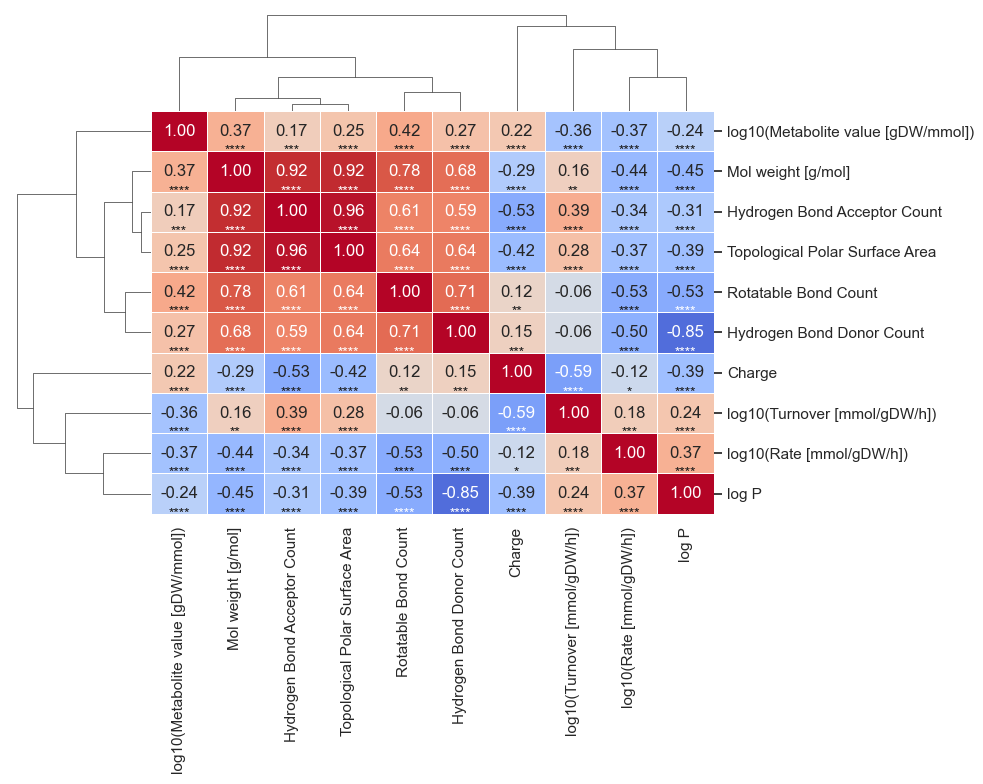

In [55]:

# Filter out rows where the species is 'C. glutamicum'
cols = [x for x in key_to_col.values() if x not in ['log10(Intracellular conc. [M])']]
df_filtered = df_mean.loc[df_mean['Species'] != 'C. glutamicum', cols]

# Select only numeric columns for correlation
numeric_cols = df_filtered.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix and p-values
correlation_matrix = numeric_cols.corr()
p_values = numeric_cols.corr(method=lambda x, y: st.pearsonr(x, y)[1])  # Compute p-values for correlations

# Create a mask for significant correlations (e.g., p < 0.05)
significance_mask = p_values < 0.05

# Create the clustermap
sns.set_theme(style="white")
clustermap = sns.clustermap(
    correlation_matrix,
    cmap="coolwarm",
    center=0,
    annot=True,  # Add correlation values to the heatmap
    fmt=".2f",   # Format for annotations
    linewidths=0.5,
    figsize=(10, 8),
    cbar_pos=None
)

# Get the reordered indices from the clustermap
reordered_rows = clustermap.dendrogram_row.reordered_ind
reordered_cols = clustermap.dendrogram_col.reordered_ind

# Reorder the correlation matrix and p-values to match the clustermap
reordered_corr = correlation_matrix.iloc[reordered_rows, reordered_cols]
reordered_pvals = p_values.iloc[reordered_rows, reordered_cols]

# Add stars for significant correlations
for i in range(reordered_corr.shape[0]):
    for j in range(reordered_corr.shape[1]):
        # print(i, j, p_values.iloc[i, j]) 
        if i == j:
            continue
        if reordered_pvals.iloc[i, j] > 0.05:  # Adjust the threshold as needed
            text = ''
        elif 0.01 < reordered_pvals.iloc[i, j] < 0.05:
            text = '*'
        elif 0.001 < reordered_pvals.iloc[i, j] < 0.01:
            text = '**'
        elif 0.0001 < reordered_pvals.iloc[i, j] < 0.001:
            text = '***'
        else:
            text = '****'

        value = reordered_corr.iloc[i, j]

        # Determine the color of the annotation based on the correlation value
        if np.abs(value) > 0.5282:
            color = 'w'
        else:
            color = 'k'

        # Add the annotation at the correct position
        clustermap.ax_heatmap.text(
            j+0.5, i+1, text, color=color, ha='center', va='center', fontsize=10
        )

plt.savefig(figure_folder / 'clustermap_correlations_with_significance.pdf', bbox_inches='tight')
# Show the plot
plt.show()